In [50]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 - Setup

In [51]:
from modules.model_selection import *
from modules.visualize import *
from modules.utils import *
from modules.feature_extraction import *
from modules.tracking import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.covariance import LedoitWolf, OAS
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

import shap


DATA_DIR = Path('./dataset')
FIGURE_DIR = Path('./figures')
CACHE_DIR = Path('./cache')
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)


# 2 - Data Loading

In [52]:
ANIMATE_ALL = False
PD_ONLY = False

In [53]:
demographic_data = DemographicData(DATA_DIR/'demographics.xlsx')
updrs_data = UPDRSdata(DATA_DIR/'motor_scales_all_2021.03.08.xlsx')
if PD_ONLY:
    pd_patients = demographic_data.get_pidns()
    updrs_data.prune(pd_patients)
    len(pd_patients)


Failed to build pose for dataset\25233\google_25233_off_gait.csv: No columns to parse from file.
Failed to build pose for dataset\25587\google_25587_off_gait.csv: No columns to parse from file.
Failed to build pose for dataset\26135\google_26135_off_gait.csv: No columns to parse from file.
Failed to build pose for dataset\26135\google_26135_on_gait.csv: No columns to parse from file.
Built 40 pose series from 25 patients.
Number of total segments: 126
Segments per Recording: 3.15 +/- 1.49
Segment Durations: 4.94 +/- 1.10 s


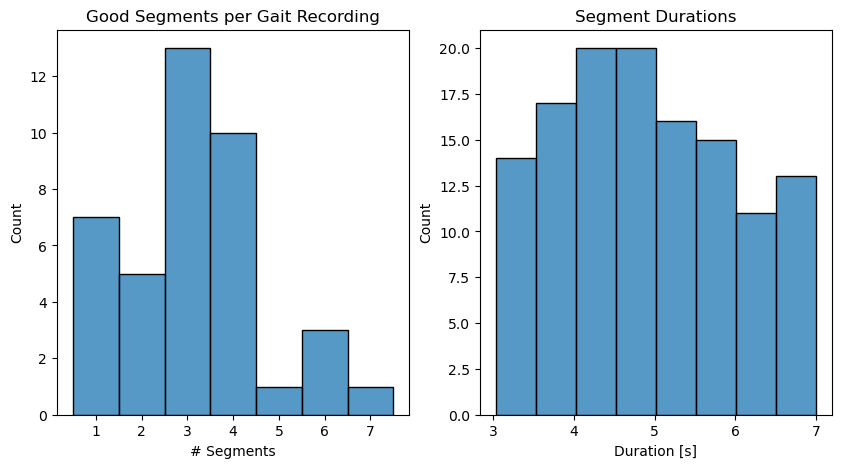

In [54]:
pose_files = sorted(list(DATA_DIR.glob('**/*gait*csv')), key=natsort)
poses = []
ids = []
for f in pose_files:
    try:
        pose = PoseSeries(f, min_duration=3, max_duration=7, tolerance=10)
        if pose.seg_cnt == 0:
            continue
        ids.append(pose.id)
        poses.append(pose)
    except Exception as e:
        print(f"Failed to build pose for {f}: {str(e)}.")
ids = np.unique(ids)
print(f"Built {len(poses)} pose series from {len(ids)} patients.")

if ANIMATE_ALL:
    for p in tqdm(poses, desc='Pose Animation'):
        p.animate(visualize=False, show_good_range=True, save_fig=True)

seg_cnts, all_segments = [], []
for p in poses:
    seg_cnts.append(p.seg_cnt)
    all_segments.extend(p.segments)
durations = [(s[1]-s[0])*p.dt for s in all_segments]

print(f'Number of total segments: {np.sum(seg_cnts)}')
print(
    f'Segments per Recording: {np.mean(seg_cnts):.2f} +/- {np.std(seg_cnts):.2f}')
print(
    f'Segment Durations: {np.mean(durations):.2f} +/- {np.std(durations):.2f} s')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(seg_cnts, ax=ax1, discrete=True)
sns.histplot(durations, ax=ax2)
ax1.set_xlabel('# Segments')
ax1.set_title('Good Segments per Gait Recording')
ax2.set_xlabel('Duration [s]')
ax2.set_title('Segment Durations')

plt.show()


Failed to build hand for dataset\21010\google_21010_fingertap.csv: No rows from which to infer column width.
Failed to build hand for dataset\22423\google_22423_on_fingertap.csv: Length mismatch: Expected axis has 68 elements, new values have 128 elements.
Failed to build hand for dataset\25233\google_25233_off_fingertap.csv: No rows from which to infer column width.
Failed to build hand for dataset\25233\google_25233_on_fingertap.csv: No rows from which to infer column width.
Built 48 hand series from 27 patients.
Number of total segments: 189
Segments per Recording: 3.94 +/- 1.53
Segment Durations: 5.74 +/- 1.04 s


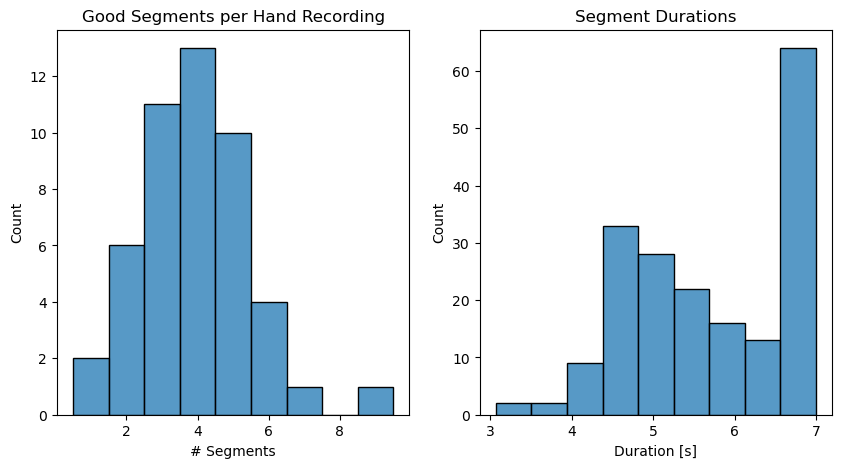

In [55]:
hand_files = sorted(list(DATA_DIR.glob('**/*fingertap*csv')), key=natsort)
hands = []
ids = []
for f in hand_files:
    try:
        hand = HandSeries(f, min_duration=3, max_duration=7, tolerance=10)
        if hand.seg_cnt == 0:
            continue
        ids.append(hand.id)
        hands.append(hand)
    except Exception as e:
        print(f"Failed to build hand for {f}: {str(e)}.")
ids = np.unique(ids)
print(f"Built {len(hands)} hand series from {len(ids)} patients.")

if ANIMATE_ALL:
    for h in tqdm(hands, desc='Fingertap Animation'):
        h.animate(visualize=False, show_good_range=True, save_fig=True)
        break

seg_cnts, all_segments = [], []
for h in hands:
    seg_cnts.append(h.seg_cnt)
    all_segments.extend(h.segments)
durations = [(s[1]-s[0])*h.dt for s in all_segments]

print(f'Number of total segments: {np.sum(seg_cnts)}')
print(
    f'Segments per Recording: {np.mean(seg_cnts):.2f} +/- {np.std(seg_cnts):.2f}')
print(
    f'Segment Durations: {np.mean(durations):.2f} +/- {np.std(durations):.2f} s')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(seg_cnts, ax=ax1, discrete=True)
sns.histplot(durations, ax=ax2)
ax1.set_xlabel('# Segments')
ax1.set_title('Good Segments per Hand Recording')
ax2.set_xlabel('Duration [s]')
ax2.set_title('Segment Durations')

plt.show()


# 3 - Feature Extraction

In [56]:
angle_joints = [
    ('nose', 'middle_shoulder', 'left_shoulder', 90),
    # ('left_elbow', 'left_shoulder', 'left_hip'),
    # ('right_elbow', 'right_shoulder', 'right_hip'),
    ('left_elbow', 'left_shoulder', 'middle_shoulder', 90),
    ('right_elbow', 'right_shoulder', 'middle_shoulder', 90),
]
distance_joints = [
    ('left_wrist', 'left_shoulder'),
    ('right_wrist', 'right_shoulder'),
    ('left_ankle', 'left_hip'),
    ('right_ankle', 'right_hip'),
]
x_displacement_joints = [
    ('left_ankle', 'right_ankle'),
    # ('left_knee', 'right_knee'),
    ('middle_shoulder', 'middle_hip'),
]
y_displacement_joints = [
    ('left_ankle', 'right_ankle'),
    ('left_shoulder', 'right_shoulder'),
    ('left_hip', 'right_hip'),
]

def min_max_diff(f1, f2, c):
    c_max = [cc + '_max' for cc in c]
    c_min = [cc + '_min' for cc in c]
    c_diff = [cc + '_diff' for cc in c]
    f_max = np.maximum(f1, f2)
    f_min = np.minimum(f1, f2)
    f_diff = f_max - f_min

    f = f_max.tolist() + f_min.tolist() + f_diff.tolist()
    c = c_max + c_min + c_diff

    f[::3] = f_max.tolist()
    f[1::3] = f_min.tolist()
    f[2::3] = f_diff.tolist()

    c[::3] = c_max
    c[1::3] = c_min
    c[2::3] = c_diff

    return f, c
    

all_feats, all_scores = [], []
feat_cols, score_cols = None, None

for i, p in enumerate(tqdm(poses)):
    info = [p.id]
    scores = updrs_data.get_all_scores(p.id, p.on_med).to_numpy().ravel()
    for j in range(p.seg_cnt):
        feats, col_names = [], []

        for joints in angle_joints:
            base_name = f'{{{joints[0]}, {joints[1]}, {joints[2]}}} (angle)'
            angle = p.get_angle(*joints)[j]
            f, c = get_all_features(angle, base_name, p.dt)
            feats.extend(f)
            col_names.extend(c)

        # hack
        for j1, j2 in zip(distance_joints, distance_joints[1:]):
            base_name = f'{{{j1[0].split("_")[-1]}, {j1[1].split("_")[-1]}}} (distance)'
            f1, c = get_all_features(p.get_distance(*j1)[j], base_name, p.dt)
            f2, _ = get_all_features(p.get_distance(*j2)[j], base_name, p.dt)
            f, c = min_max_diff(f1, f2, c)
            feats.extend(f)
            col_names.extend(c)

        for joints in x_displacement_joints:
            base_name = f'{{{joints[0]}, {joints[1]}}} (x_displacement)'
            x_displacement = p.get_x_displacement(*joints)[j]
            f, c = get_all_features(x_displacement, base_name, p.dt)
            feats.extend(f)
            col_names.extend(c)

        for joints in y_displacement_joints:
            base_name = f'{{{joints[0]}, {joints[1]}}} (y_displacement)'
            y_displacement = p.get_y_displacement(*joints)[j]
            f, c = get_all_features(y_displacement, base_name, p.dt)
            feats.extend(f)
            col_names.extend(c)

        all_feats.append(np.concatenate([info, feats]))
        all_scores.append(np.concatenate([info, scores]))
        feat_cols = np.concatenate([['pidn'], col_names])
        score_cols = np.concatenate([['pidn'], UPDRSdata.score_names])

feat_df = pd.DataFrame(all_feats, columns=feat_cols).set_index('pidn')
score_df = pd.DataFrame(all_scores, columns=score_cols).set_index('pidn')
feat_df.to_csv(CACHE_DIR/'gait_features.csv')
score_df.to_csv(CACHE_DIR/'gait_scores.csv')


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


In [57]:
distance_joints = [
    ('right_thumb', 'right_index'),
    ('left_thumb', 'left_index'),

    ('right_middle', 'right_wrist'),
    ('left_middle', 'left_wrist'),

    ('right_ring', 'right_wrist'),
    ('left_ring', 'left_wrist'),

    ('right_pinky', 'right_wrist'),
    ('left_pinky', 'left_wrist'),
]

all_feats, all_scores = [], []
feat_cols, score_cols = None, None
is_right = []

for i, h in enumerate(tqdm(hands)):
    info = [h.id]
    scores = updrs_data.get_all_scores(h.id, h.on_med).to_numpy().ravel()
    for j in range(h.seg_cnt):
        feats, col_names = [], []

        wrist_r = h.get_joint('right_wrist', raw=True)[j][:, 1]
        wrist_l = h.get_joint('left_wrist', raw=True)[j][:, 1]
        is_right = wrist_r.mean() < wrist_l.mean()  # note: for y-coordinate, top is 0

        for (joints_r, joints_l) in zip(distance_joints[::2], distance_joints[1::2]):
            distance_r = h.get_distance(*joints_r)[j]
            distance_l = h.get_distance(*joints_l)[j]
            distance = distance_r if is_right else distance_l

            base_name = f"{{{joints_r[0].split('_')[-1]}, {joints_r[1].split('_')[-1]}}} (distance)"
            f, c = get_all_features(distance, base_name, h.dt)
            feats.extend(f)
            col_names.extend(c)

        all_feats.append(np.concatenate([info, feats]))
        all_scores.append(np.concatenate([info, scores]))
        feat_cols = np.concatenate([['pidn'], col_names])
        score_cols = np.concatenate([['pidn'], UPDRSdata.score_names])

feat_df = pd.DataFrame(all_feats, columns=feat_cols).set_index('pidn')
score_df = pd.DataFrame(all_scores, columns=score_cols).set_index('pidn')
feat_df.to_csv(CACHE_DIR/'fingertap_features.csv')
score_df.to_csv(CACHE_DIR/'fingertap_scores.csv')


100%|██████████| 48/48 [00:01<00:00, 46.95it/s]


# 4 - Data Analysis

In [58]:
gait_features = pd.read_csv(CACHE_DIR/'gait_features.csv', index_col=0)
gait_scores = pd.read_csv(CACHE_DIR/'gait_scores.csv', index_col=0)

gait_features['id'] = np.arange(len(gait_features))
gait_scores['id'] = np.arange(len(gait_scores))

mask = ~gait_scores.isna().any(axis=1)
mask &= ~gait_features.isna().any(axis=1)
gait_features = gait_features[mask]
gait_scores = gait_scores[mask]

gait_labels = gait_scores[['3.total', 'id']]
low = gait_labels['3.total'] <= 32
gait_labels.loc[low, '3.total'] = 0
gait_labels.loc[~low, '3.total'] = 1
gait_labels = gait_labels.rename(columns={'3.total': 'label'}).astype(int)

tmp = gait_features.reset_index().set_index(['pidn'])
print(f'Samping from {len(np.unique(tmp.index))} valid patient entries:')
print(
    f'    Feature Matrix: {gait_features.shape[0]} x {gait_features.shape[1]}')
print()
print(f'Total Score Labels [Cutoff = 32]:')
print(f'    # Mild: {gait_labels.value_counts(subset="label")[0]}')
print(f'    # Severe: {gait_labels.value_counts(subset="label")[1]}')


Samping from 23 valid patient entries:
    Feature Matrix: 120 x 443

Total Score Labels [Cutoff = 32]:
    # Mild: 61
    # Severe: 59


In [59]:
ft_features = pd.read_csv(CACHE_DIR/'fingertap_features.csv', index_col=0)
ft_scores = pd.read_csv(CACHE_DIR/'fingertap_scores.csv', index_col=0)

ft_features['id'] = np.arange(len(ft_features))
ft_scores['id'] = np.arange(len(ft_scores))

mask = ~ft_scores.isna().any(axis=1)
mask &= ~ft_features.isna().any(axis=1)
ft_features = ft_features[mask]
ft_scores = ft_scores[mask]

ft_labels = ft_scores[['3.total', 'id']]
low = ft_labels['3.total'] <= 32
ft_labels.loc[low, '3.total'] = 0
ft_labels.loc[~low, '3.total'] = 1
ft_labels = ft_labels.rename(columns={'3.total': 'label'}).astype(int)

tmp = ft_features.reset_index().set_index(['pidn'])
print(f'Samping from {len(np.unique(tmp.index))} valid patient entries:')
print(f'    Feature Matrix: {ft_features.shape[0]} x {ft_features.shape[1]}')
print()
print(f'Total Score Labels [Cutoff = 32]:')
print(f'    # Mild: {ft_labels.value_counts(subset="label")[0]}')
print(f'    # Severe: {ft_labels.value_counts(subset="label")[1]}')


Samping from 25 valid patient entries:
    Feature Matrix: 183 x 105

Total Score Labels [Cutoff = 32]:
    # Mild: 80
    # Severe: 103


In [60]:
int_features = gait_features.reset_index().merge(
    ft_features.drop('id', axis=1).reset_index(), on='pidn')
int_features = int_features.set_index('pidn')

int_scores = []
for id in int_features['id']:
    int_scores.append(gait_scores[gait_scores['id'] == id])
int_scores = pd.concat(int_scores)

int_labels = int_scores[['3.total', 'id']]
low = int_labels['3.total'] <= 32
int_labels.loc[low, '3.total'] = 0
int_labels.loc[~low, '3.total'] = 1
int_labels = int_labels.rename(columns={'3.total': 'label'}).astype(int)

tmp = int_features.reset_index().set_index(['pidn'])
tmp2 = int_features.drop_duplicates(subset="id")
print(f'Samping from {len(np.unique(tmp.index))} valid patient entries:')
print(
    f'    Feature Matrix: {int_features.shape[0]} x {int_features.shape[1]}')
print()

tmp = int_labels.drop_duplicates(subset='id')
print(f'Total Score Labels [Cutoff = 32]:')
print(f'    # Mild: {int_labels.value_counts(subset="label")[0]}')
print(f'    # Severe: {int_labels.value_counts(subset="label")[1]}')
print()


Samping from 20 valid patient entries:
    Feature Matrix: 824 x 547

Total Score Labels [Cutoff = 32]:
    # Mild: 382
    # Severe: 442



### Eval

In [61]:
EVAL = True
params = defaultdict(dict)

In [105]:
models = {
    'SVM': LinearSVC(penalty='l1', C=5, dual=False, max_iter=5000, fit_intercept=False),
    'LR': LogisticRegression(penalty='l1', C=10, solver='liblinear', fit_intercept=False),
    'LDA': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
    'RF': RandomForestClassifier(max_depth=7),
    'AB': AdaBoostClassifier(learning_rate=1e-1),
    'KNN': KNeighborsClassifier(n_neighbors=8),
    'GNB': GaussianNB(),
}

if EVAL:
    results = eval_all(models, params, gait_features, gait_labels, n_repeats=10, alpha=0.1)
    with open(CACHE_DIR/'gait.dat', 'wb') as f:
        pickle.dump(results, f)

SVM:   0%|          | 0/10 [00:00<?, ?it/s]

LR:   0%|          | 0/10 [00:00<?, ?it/s]

LDA:   0%|          | 0/10 [00:00<?, ?it/s]

RF:   0%|          | 0/10 [00:00<?, ?it/s]

AB:   0%|          | 0/10 [00:00<?, ?it/s]

KNN:   0%|          | 0/10 [00:00<?, ?it/s]

GNB:   0%|          | 0/10 [00:00<?, ?it/s]

In [116]:
models = {
    'SVM': LinearSVC(penalty='l1', C=0.02, dual=False, max_iter=5000, fit_intercept=False),
    'LR': LogisticRegression(penalty='l1', C=0.05, solver='liblinear', fit_intercept=False),
    'LDA': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
    'RF': RandomForestClassifier(max_depth=7),
    'AB': AdaBoostClassifier(learning_rate=1),
    'KNN': KNeighborsClassifier(n_neighbors=2),
    'GNB': GaussianNB(),
}

if EVAL:
    results = eval_all(models, params, ft_features, ft_labels, n_repeats=10, alpha=0.1)
    with open(CACHE_DIR/'fingertap.dat', 'wb') as f:
        pickle.dump(results, f)


SVM:   0%|          | 0/10 [00:00<?, ?it/s]

LR:   0%|          | 0/10 [00:00<?, ?it/s]

LDA:   0%|          | 0/10 [00:00<?, ?it/s]

RF:   0%|          | 0/10 [00:00<?, ?it/s]

AB:   0%|          | 0/10 [00:00<?, ?it/s]

KNN:   0%|          | 0/10 [00:00<?, ?it/s]

GNB:   0%|          | 0/10 [00:00<?, ?it/s]

In [118]:
models = {
    'SVM': LinearSVC(penalty='l1', C=0.003, dual=False, max_iter=5000, fit_intercept=False),
    'LR': LogisticRegression(penalty='l1', C=0.01, solver='liblinear', fit_intercept=False),
    'LDA': LinearDiscriminantAnalysis(shrinkage=0.6, solver='lsqr'),
    'RF': RandomForestClassifier(max_depth=7),
    'AB': AdaBoostClassifier(learning_rate=0.7),
    'KNN': KNeighborsClassifier(n_neighbors=2),
    'GNB': GaussianNB(),
}

if EVAL:
    results = eval_all(models, params, int_features, int_labels, n_repeats=10, alpha=0.1)
    with open(CACHE_DIR/'integrated.dat', 'wb') as f:
        pickle.dump(results, f)


SVM:   0%|          | 0/10 [00:00<?, ?it/s]

LR:   0%|          | 0/10 [00:00<?, ?it/s]

LDA:   0%|          | 0/10 [00:00<?, ?it/s]

RF:   0%|          | 0/10 [00:00<?, ?it/s]

AB:   0%|          | 0/10 [00:00<?, ?it/s]

KNN:   0%|          | 0/10 [00:00<?, ?it/s]

GNB:   0%|          | 0/10 [00:00<?, ?it/s]

### Visualize

Body: mean=11.70, std=1.90
Hand: mean=3.60, std=0.49
Combined: mean=11.15, std=0.91


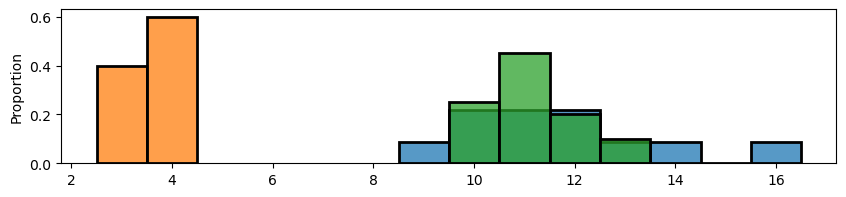

In [119]:
def get_count(results):
    selected = []
    for _, v in results['selected'].items():
        selected.extend(v)
    counts = [len(s) for s in selected]
    return np.array(counts)

with open('./cache/gait.dat', 'rb') as f:
    a = pickle.load(f)
with open('./cache/fingertap.dat', 'rb') as f:
    b = pickle.load(f)
with open('./cache/integrated.dat', 'rb') as f:
    c = pickle.load(f)

aa = get_count(a)
bb = get_count(b)
cc = get_count(c)

fig = plt.figure(figsize=(10, 2))
sns.histplot(data=aa, discrete=True, stat='proportion', ax=plt.gca(), linewidth=2)
sns.histplot(data=bb, discrete=True, stat='proportion', ax=plt.gca(), linewidth=2)
sns.histplot(data=cc, discrete=True, stat='proportion', ax=plt.gca(), linewidth=2)

plt.savefig(FIGURE_DIR/'lasso.png')

print(f'Body: mean={aa.mean():.2f}, std={aa.std():.2f}')
print(f'Hand: mean={bb.mean():.2f}, std={bb.std():.2f}')
print(f'Combined: mean={cc.mean():.2f}, std={cc.std():.2f}')

In [120]:
with open('./cache/gait.dat', 'rb') as f:
    results = pickle.load(f)
gait_selected = VisualizeAll(gait_features, gait_labels, results, out_dir=FIGURE_DIR/'g')


     acc_mean  acc_std  auc_mean  auc_std   acc_ci_99_9
SVM     0.708    0.000     0.761    0.000  0.000000e+00
LR      0.709    0.003     0.762    0.000  4.051621e-03
LDA     0.567    0.000     0.628    0.000  0.000000e+00
RF      0.592    0.021     0.584    0.012  3.205968e-02
AB      0.558    0.000     0.622    0.000  0.000000e+00
KNN     0.581    0.000     0.610    0.000  0.000000e+00
GNB     0.593    0.000     0.664    0.000  1.769293e-16


iteritems is deprecated and will be removed in a future version. Use .items instead.
The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.


                                                 feat   freq      p
0        {ankle, hip} (distance) - |temporal| mad_max  0.783  0.001
7   {left_ankle, right_ankle} (x_displacement) - |...  1.000  0.000
16  {left_elbow, left_shoulder, middle_shoulder} (...  1.000  0.000
18  {left_shoulder, right_shoulder} (y_displacemen...  0.826  0.005
21  {nose, middle_shoulder, left_shoulder} (angle)...  0.913  0.000
24  {right_elbow, right_shoulder, middle_shoulder}...  1.000  0.004
25  {wrist, shoulder} (distance) - |temporal| mad_...  1.000  0.000


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x2000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [122]:
with open('./cache/fingertap.dat', 'rb') as f:
    results = pickle.load(f)
ft_selected = VisualizeAll(ft_features, ft_labels, results, out_dir=FIGURE_DIR/'ft')


     acc_mean  acc_std  auc_mean  auc_std   acc_ci_99_9
SVM     0.668    0.000     0.699    0.000  1.769293e-16
LR      0.676    0.000     0.672    0.000  0.000000e+00
LDA     0.673    0.000     0.691    0.000  0.000000e+00
RF      0.662    0.013     0.663    0.005  1.918926e-02
AB      0.630    0.000     0.623    0.000  1.769293e-16
KNN     0.549    0.000     0.580    0.000  0.000000e+00
GNB     0.697    0.000     0.705    0.000  0.000000e+00


iteritems is deprecated and will be removed in a future version. Use .items instead.
The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.


                                                feat  freq    p
0         {thumb, index} (distance) - |temporal| mad   1.0  0.0
3  {thumb, index} (distance) {diff} - |spectral| ...   1.0  0.0
4  {thumb, index} (distance) {diff} - |temporal| mad   1.0  0.0


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x2000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [123]:
with open('./cache/integrated.dat', 'rb') as f:
    results = pickle.load(f)
int_selected = VisualizeAll(int_features, int_labels, results, out_dir=FIGURE_DIR/'int')


     acc_mean  acc_std  auc_mean  auc_std  acc_ci_99_9
SVM     0.747     0.00     0.816    0.000     0.000000
LR      0.743     0.00     0.809    0.000     0.000000
LDA     0.665     0.00     0.712    0.000     0.000000
RF      0.636     0.01     0.663    0.008     0.015485
AB      0.616     0.00     0.644    0.000     0.000000
KNN     0.642     0.00     0.652    0.000     0.000000
GNB     0.662     0.00     0.703    0.000     0.000000


iteritems is deprecated and will be removed in a future version. Use .items instead.
The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.


                                                 feat  freq    p
4   {left_ankle, right_ankle} (x_displacement) - |...  1.00  0.0
9   {left_elbow, left_shoulder, middle_shoulder} (...  0.85  0.0
10  {left_shoulder, right_shoulder} (y_displacemen...  0.90  0.0
16  {pinky, wrist} (distance) {diff} - |spectral| ...  1.00  0.0
20         {thumb, index} (distance) - |temporal| mad  1.00  0.0
23  {thumb, index} (distance) {diff} - |spectral| ...  1.00  0.0
26  {wrist, shoulder} (distance) - |temporal| mad_...  1.00  0.0


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x2000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [ ]:
df = int_selected.set_index('feat')
s, sv = model_shap(RandomForestClassifier(n_jobs=-1), int_features, int_labels, selected=df.index)


In [ ]:
shap.summary_plot(shap_values=sv[1], features=s[0], feature_names=df.index, plot_size=(15,10))
plt.savefig(FIGURE_DIR/'shap1.png')

In [ ]:
shap.summary_plot(shap_values=sv[1], features=s[0], feature_names=df.index, plot_size=(15,15), plot_type="bar")
plt.savefig(FIGURE_DIR/'shap2.png')
